In [178]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

In [98]:
from IPython.display import display
import graphviz 
from sklearn.tree import export_graphviz
import seaborn as sns
from matplotlib import pyplot as plt

In [144]:
import time

In [3]:
#for i in range(10):
#    display(i)

# Extracting the data

In [4]:
!curl https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv >CreditScoring.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  178k  100  178k    0     0   971k      0 --:--:-- --:--:-- --:--:-- 1006k


In [5]:
!head CreditScoring.csv

"Status","Seniority","Home","Time","Age","Marital","Records","Job","Expenses","Income","Assets","Debt","Amount","Price"
1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
1,0,1,36,26,1,1,1,46,107,0,0,310,910
1,1,2,60,36,2,1,1,75,214,3500,0,650,1645
1,29,2,60,44,2,1,1,75,125,10000,0,1600,1800
1,9,5,12,27,1,1,1,35,80,0,0,200,1093
1,0,2,60,32,2,1,3,90,107,15000,0,1200,1957


# Loading and transforming the data

In [6]:
df = pd.read_csv("CreditScoring.csv")

In [7]:
df.shape

(4455, 14)

In [8]:
df.columns

Index(['Status', 'Seniority', 'Home', 'Time', 'Age', 'Marital', 'Records',
       'Job', 'Expenses', 'Income', 'Assets', 'Debt', 'Amount', 'Price'],
      dtype='object')

In [9]:
# Lower case column names
df.columns = df.columns.str.lower()

In [10]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [11]:
df.dtypes

status       int64
seniority    int64
home         int64
time         int64
age          int64
marital      int64
records      int64
job          int64
expenses     int64
income       int64
assets       int64
debt         int64
amount       int64
price        int64
dtype: object

Categorical variables have been label encoded in the dataset, which we want to undo

In [12]:
categorical_variables = ['status', 'home', 'marital', 'records','job']
for c in categorical_variables:
    print(df[c].value_counts())
    print("****")


status
1    3200
2    1254
0       1
Name: count, dtype: int64
****
home
2    2107
1     973
5     783
6     319
3     247
4      20
0       6
Name: count, dtype: int64
****
marital
2    3241
1     978
4     130
3      67
5      38
0       1
Name: count, dtype: int64
****
records
1    3682
2     773
Name: count, dtype: int64
****
job
1    2806
3    1024
2     452
4     171
0       2
Name: count, dtype: int64
****


In [13]:
variable_values = {}
variable_values["status"] = {0:"unknown", 1:"good", 2:"bad"}
variable_values["home"] = {0:"unknown", 1:"rent", 2:"owner", 3:"priv", 4:"ignore", 5:"parents", 6:"other"}
variable_values["marital"] = {0:"unknown", 1:"single", 2:"married", 3:"widow", 4:"separated", 5:"divorced"}
variable_values["records"] = {0:"unknown", 1:"no", 2:"yes"}
variable_values["job"] = {0:"unknown", 1:"fixed", 2:"part_time", 3:"freelance", 4:"others"}



In [14]:
for c in variable_values:
    df[c] = df[c].map(variable_values[c])

In [15]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,good,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,good,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,bad,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,good,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,good,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [16]:
df.dtypes

status       object
seniority     int64
home         object
time          int64
age           int64
marital      object
records      object
job          object
expenses      int64
income        int64
assets        int64
debt          int64
amount        int64
price         int64
dtype: object

In [17]:
set(df.dtypes[df.dtypes == object].index) == set(categorical_variables)

True

In [18]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


missing values (coded as 99999999) !!

In [19]:
for c in df.columns:
    if c not in categorical_variables:
        df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [20]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [21]:
for c in categorical_variables:
    df = df[df[c]!= "unknown"]

In [22]:
df = df.reset_index(drop=True)

In [23]:
df

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,good,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,good,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,bad,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,good,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,good,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4441,bad,1,rent,60,39,married,no,fixed,69,92.0,0.0,0.0,900,1020
4442,good,22,owner,60,46,married,no,fixed,60,75.0,3000.0,600.0,950,1263
4443,bad,0,owner,24,37,married,no,part_time,60,90.0,3500.0,0.0,500,963
4444,good,0,rent,48,23,single,no,freelance,49,140.0,0.0,0.0,550,550


## Split into train, val and test datasets

In [24]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) # 0.25*0.8 = 0.2 = val size, so 60-20-20 split

In [25]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [26]:
df_train.shape, df_val.shape, df_test.shape

((2667, 14), (889, 14), (890, 14))

In [27]:
y_train = (df_train["status"] == "bad").astype(int).values
y_val = (df_val["status"] == "bad").astype(int).values
y_test = (df_test["status"] == "bad").astype(int).values

In [28]:
y_train.shape, y_val.shape, y_test.shape

((2667,), (889,), (890,))

In [29]:
del df_train["status"]
del df_val["status"]
del df_test["status"]

# Construct feature matrix

In [30]:
train_dict = df_train.fillna(0).to_dict(orient='records') #turn each row into a dictionary

In [31]:
train_dict[0] #first row

{'seniority': 4,
 'home': 'owner',
 'time': 60,
 'age': 26,
 'marital': 'married',
 'records': 'no',
 'job': 'fixed',
 'expenses': 45,
 'income': 152.0,
 'assets': 4000.0,
 'debt': 1200.0,
 'amount': 950,
 'price': 1050}

In [32]:
v = DictVectorizer(sparse=False)

In [33]:
X_train = v.fit_transform(train_dict) # does one hot encoding of the categorical variables in the process

In [34]:
X_train.shape

(2667, 26)

In [35]:
df_train.shape

(2667, 13)

In [36]:
v.get_feature_names_out()

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=priv',
       'home=rent', 'income', 'job=fixed', 'job=freelance', 'job=others',
       'job=part_time', 'marital=divorced', 'marital=married',
       'marital=separated', 'marital=single', 'marital=widow', 'price',
       'records=no', 'records=yes', 'seniority', 'time'], dtype=object)

# Train decision tree

In [37]:
tree = DecisionTreeClassifier()

In [38]:
tree.fit(X_train, y_train)

DecisionTreeClassifier()

# Validation

In [39]:
val_dict = df_val.fillna(0).to_dict(orient='records') #turn each row into a dictionary
X_val = v.transform(val_dict)

In [40]:
y_val_pred = tree.predict_proba(X_val)

In [41]:
y_val_pred

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [42]:
y_val_pred = y_val_pred[:, 1]

In [43]:
y_val_pred

array([0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 1.

In [44]:
roc_auc_score(y_train, tree.predict_proba(X_train)[:,1]) #overfitting on training data

1.0

In [45]:
roc_auc_score(y_val, y_val_pred) # overfitting leads to poor score on validation data

0.6650011186516519

In [46]:
# hyperparameters
better_tree = DecisionTreeClassifier(max_depth=3)
better_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

In [47]:
roc_auc_score(y_train, better_tree.predict_proba(X_train)[:,1])

0.7660357518401681

In [48]:
roc_auc_score(y_val, better_tree.predict_proba(X_val)[:,1])

0.7612859522211449

# Visualizing

In [49]:
print(export_text(tree))

|--- feature_24 <= 2.50
|   |--- feature_22 <= 0.50
|   |   |--- feature_12 <= 0.50
|   |   |   |--- feature_0 <= 54.50
|   |   |   |   |--- feature_1 <= 925.00
|   |   |   |   |   |--- feature_21 <= 1228.50
|   |   |   |   |   |   |--- feature_1 <= 875.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_1 >  875.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- feature_21 >  1228.50
|   |   |   |   |   |   |--- feature_11 <= 72.50
|   |   |   |   |   |   |   |--- feature_11 <= 9.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- feature_11 >  9.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- feature_11 >  72.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- feature_1 >  925.00
|   |   |   |   |   |--- feature_11 <= 152.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_11 >  152.50
|   |   |   |   |   |   |--- feature_4 <= 40.00
|   |   

In [50]:
print(export_text(better_tree))

|--- feature_24 <= 2.50
|   |--- feature_23 <= 0.50
|   |   |--- feature_11 <= 95.50
|   |   |   |--- class: 1
|   |   |--- feature_11 >  95.50
|   |   |   |--- class: 0
|   |--- feature_23 >  0.50
|   |   |--- feature_12 <= 0.50
|   |   |   |--- class: 1
|   |   |--- feature_12 >  0.50
|   |   |   |--- class: 1
|--- feature_24 >  2.50
|   |--- feature_11 <= 71.50
|   |   |--- feature_2 <= 3586.00
|   |   |   |--- class: 1
|   |   |--- feature_2 >  3586.00
|   |   |   |--- class: 0
|   |--- feature_11 >  71.50
|   |   |--- feature_23 <= 0.50
|   |   |   |--- class: 0
|   |   |--- feature_23 >  0.50
|   |   |   |--- class: 0



In [51]:
print(export_text(better_tree, feature_names = v.get_feature_names_out()))

|--- seniority <= 2.50
|   |--- records=yes <= 0.50
|   |   |--- income <= 95.50
|   |   |   |--- class: 1
|   |   |--- income >  95.50
|   |   |   |--- class: 0
|   |--- records=yes >  0.50
|   |   |--- job=fixed <= 0.50
|   |   |   |--- class: 1
|   |   |--- job=fixed >  0.50
|   |   |   |--- class: 1
|--- seniority >  2.50
|   |--- income <= 71.50
|   |   |--- assets <= 3586.00
|   |   |   |--- class: 1
|   |   |--- assets >  3586.00
|   |   |   |--- class: 0
|   |--- income >  71.50
|   |   |--- records=yes <= 0.50
|   |   |   |--- class: 0
|   |   |--- records=yes >  0.50
|   |   |   |--- class: 0



### Using graphviz

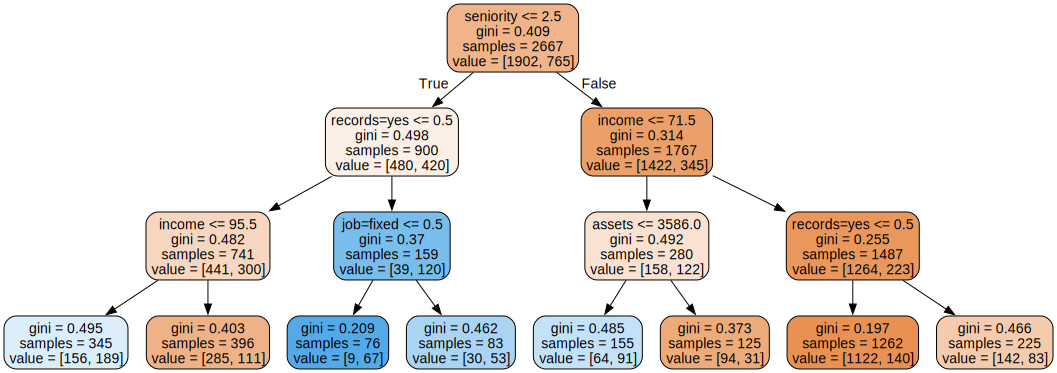

In [55]:
dot_data = export_graphviz(
            better_tree,
            out_file=None,
            feature_names=v.get_feature_names_out(),
            rounded=True,
            filled=True
        )
    
    
prettier_graph = graphviz.Source(dot_data)  
prettier_graph

# Hyperparameter tuning

In [58]:
max_depths = [1,2,3,4,5,6,10,15,20,None]
num_min_samples_leaf = [1,2,5,10,15,20,50,100,200]

scores = []
for max_depth in max_depths:
    for min_samples_leaf in num_min_samples_leaf:
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        tree.fit(X_train, y_train)
        y_val_pred = tree.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_val_pred)
        scores.append([max_depth, min_samples_leaf, auc])

scores_df = pd.DataFrame(scores, columns = ["max_depth", "min_samples_leaf", "auc"])
        

In [83]:
scores_df = scores_df.sort_values(by="auc", ascending=False).reset_index(drop=True)
scores_df = scores_df.fillna(value=math.inf)
scores_df.head()

,max_depth,min_samples_leaf,auc
0,10.0,20,0.788326
1,15.0,20,0.788062
2,inf,20,0.786527
3,20.0,20,0.784914
4,20.0,100,0.779504


In [84]:
pivoted_scores = scores_df.pivot(index = "max_depth", columns = "min_samples_leaf", values = "auc")
pivoted_scores

min_samples_leaf,1,2,5,10,15,20,50,100,200
max_depth,,,,,,,,,
1.0,0.635913,0.635913,0.635913,0.635913,0.635913,0.635913,0.635913,0.635913,0.635913
2.0,0.684254,0.684254,0.684254,0.684254,0.684254,0.684254,0.684254,0.684254,0.681790
3.0,0.761286,0.761286,0.761286,0.761286,0.761286,0.761286,0.761286,0.760845,0.724799
4.0,0.765761,0.765761,0.769486,0.771776,0.771776,0.771776,0.769337,0.777932,0.732008
5.0,0.767902,0.767902,0.770366,0.774405,0.771630,0.770745,0.765540,0.773607,0.735442
6.0,0.763377,0.761737,0.755366,0.764375,0.775154,0.774850,0.772479,0.777068,0.737176
10.0,0.677772,0.701550,0.723516,0.759885,0.773190,0.788326,0.772721,0.779504,0.737176
15.0,0.654946,0.705095,0.714623,0.754894,0.766298,0.788062,0.772721,0.779504,0.737176
20.0,0.663789,0.698716,0.716667,0.758952,0.772622,0.784914,0.772721,0.779504,0.737176


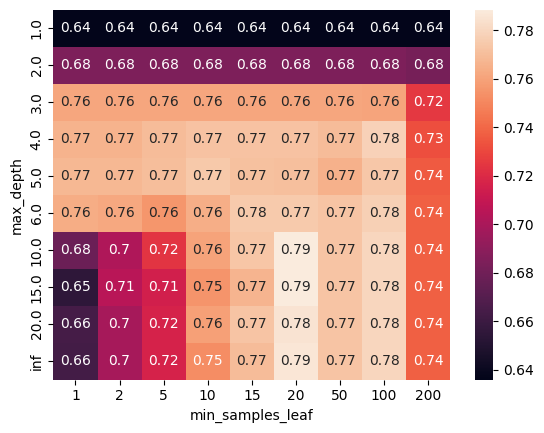

In [85]:
sns.heatmap(pivoted_scores, annot=True);

# GridCV

In [105]:
gs = GridSearchCV(
    DecisionTreeClassifier(random_state=1),
    param_grid={"min_samples_leaf": num_min_samples_leaf},
    scoring="roc_auc",
    refit=True,
    n_jobs=None,
    return_train_score=True,
)
gs.fit(X_train, y_train)
results = gs.cv_results_

In [106]:
results_df = pd.DataFrame(results).sort_values(by="mean_test_score", ascending=False).reset_index(drop=True)

In [107]:
results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.004959,0.000114,0.001210,0.000019,50,{'min_samples_leaf': 50},0.816067,0.773155,0.753586,0.762470,...,0.785027,0.027622,1,0.827340,0.839589,0.842985,0.840988,0.829437,0.836068,0.006397
1,0.006396,0.000237,0.001256,0.000034,20,{'min_samples_leaf': 20},0.812833,0.737953,0.749364,0.767905,...,0.772638,0.027888,2,0.872124,0.879301,0.879708,0.882271,0.879134,0.878508,0.003388
2,0.007503,0.000351,0.001407,0.000092,15,{'min_samples_leaf': 15},0.803819,0.736435,0.746603,0.773400,...,0.771503,0.026687,3,0.891432,0.895715,0.898919,0.902356,0.901493,0.897983,0.004009
3,0.004051,0.000227,0.001245,0.000073,100,{'min_samples_leaf': 100},0.785961,0.749696,0.785561,0.738304,...,0.768273,0.020195,4,0.789238,0.814137,0.812350,0.812969,0.790808,0.803900,0.011356
4,0.008764,0.000416,0.001724,0.000229,10,{'min_samples_leaf': 10},0.763617,0.744781,0.738983,0.755796,...,0.757581,0.016039,5,0.918353,0.921649,0.916020,0.922843,0.921974,0.920168,0.002573


In [108]:
results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_min_samples_leaf', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

[  1.   2.   5.  10.  15.  20.  50. 100. 200.]


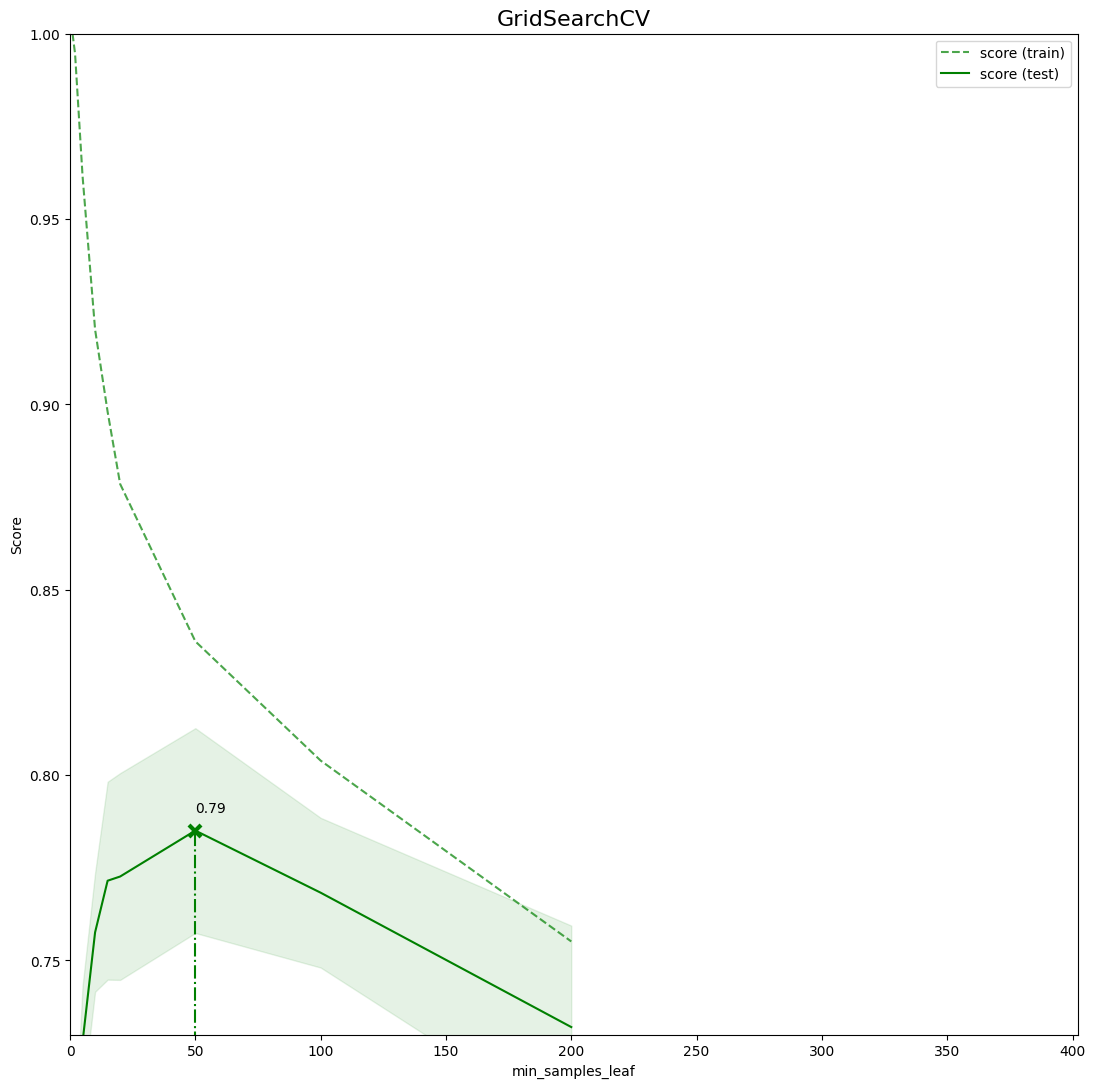

In [111]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV", fontsize=16)

plt.xlabel("min_samples_leaf")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results["param_min_samples_leaf"].data, dtype=float)

print(X_axis)
for scorer, color in zip(["score"], ["g"]):
    for sample, style in (("train", "--"), ("test", "-")):
        sample_score_mean = results["mean_%s_%s" % (sample, scorer)]
        sample_score_std = results["std_%s_%s" % (sample, scorer)]
        ax.fill_between(
            X_axis,
            sample_score_mean - sample_score_std,
            sample_score_mean + sample_score_std,
            alpha=0.1 if sample == "test" else 0,
            color=color,
        )
        ax.plot(
            X_axis,
            sample_score_mean,
            style,
            color=color,
            alpha=1 if sample == "test" else 0.7,
            label="%s (%s)" % (scorer, sample),
        )

    best_index = np.nonzero(results["rank_test_%s" % scorer] == 1)[0][0]
    best_score = results["mean_test_%s" % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x

    ax.plot(
        [
            X_axis[best_index],
        ]
        * 2,
        [0, best_score],
        linestyle="-.",
        color=color,
        marker="x",
        markeredgewidth=3,
        ms=8,
    )

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))
    

plt.legend(loc="best")
plt.grid(False)
plt.show()

# Random Forest

In [135]:
rf = RandomForestClassifier(n_estimators = 10, random_state=1)

In [136]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [137]:
y_val_pred = rf.predict_proba(X_val)[:,1]

In [138]:
roc_auc_score(y_val, y_val_pred)

0.8121069182389937

In [139]:
X_val[[0]].shape

(1, 26)

In [140]:
X_val[0].shape

(26,)

In [141]:
X_val[0].reshape(-1,1).shape, X_val[0].reshape(1,-1).shape

((26, 1), (1, 26))

In [142]:
rf.predict_proba(X_val[0].reshape(1,-1))

array([[0.8, 0.2]])

In [143]:
rf.predict_proba(X_val[[0]])

array([[0.8, 0.2]])

# Feature importances

In [168]:
start_time = time.time()
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.006 seconds


In [177]:
np.array([tree.feature_importances_ for tree in rf.estimators_])

array([[8.67820219e-02, 1.42440045e-01, 5.75920962e-02, 2.29555422e-02,
        4.83477168e-02, 1.53891063e-03, 6.41313859e-03, 3.19727785e-02,
        1.46969328e-02, 4.09679674e-03, 4.35032073e-03, 1.83413878e-01,
        3.52075663e-02, 1.54980477e-02, 7.93694193e-03, 1.70000695e-02,
        3.50575556e-06, 1.24335114e-02, 7.70901108e-03, 9.85532612e-03,
        8.47796243e-04, 1.29558529e-01, 3.03398866e-02, 2.06771489e-02,
        7.11592745e-02, 3.71732073e-02],
       [1.03954095e-01, 1.01376398e-01, 1.03418848e-01, 2.72198486e-02,
        5.71214330e-02, 1.60475439e-03, 9.02032959e-03, 8.91011925e-03,
        1.51564489e-02, 7.66307569e-03, 2.37982700e-02, 1.40957508e-01,
        1.72870977e-02, 6.25519908e-03, 5.17038493e-03, 2.26804489e-02,
        3.01208578e-03, 1.68364700e-02, 5.95781297e-03, 9.51348478e-03,
        0.00000000e+00, 1.35042194e-01, 6.53497021e-03, 4.03024984e-02,
        9.53897238e-02, 3.58165013e-02],
       [8.08516347e-02, 1.29384462e-01, 5.08793292e-02

In [170]:
importances.shape # importances : each feature has an importance

(26,)

In [171]:
len(v.get_feature_names_out())

26

In [172]:
np.mean([[1,1],[2,2]], axis=0) # axis = 0, column wise aggregation

array([1.5, 1.5])

In [173]:
np.mean([[1,1],[2,2]], axis=1) # axis = 1, row wise aggregation

array([1., 2.])

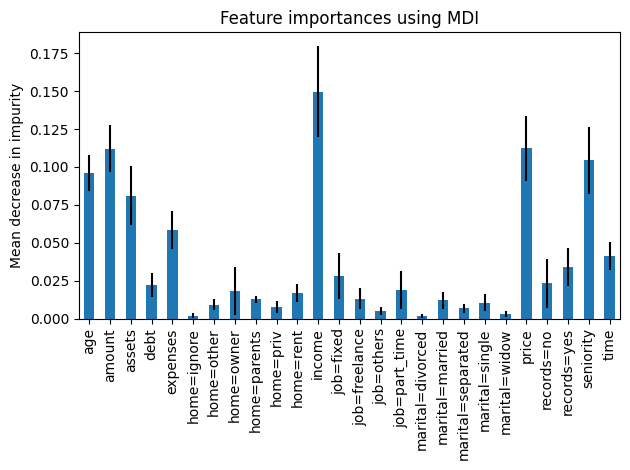

In [175]:
forest_importances = pd.Series(importances, index=v.get_feature_names_out())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Mean decrease in impurity will be higher for features with higher cardinality/numerical features

## Permutation importance

On a validation set, measure model accuracy. Then permute feature values for a feature and measure drop in accuracy
Problems : if 2 features A, B are correlated and you permute A, (but B is intact), then model can use value of B and not show that much drop in accuracy of A ... making A seem less important to model

In [181]:
start_time = time.time()
result = permutation_importance(
    rf, X_val, y_val, n_repeats=10, random_state=1, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")
result


Elapsed time to compute the importances: 0.394 seconds


{'importances_mean': array([ 9.22384702e-03,  2.72215973e-02,  1.23734533e-02, -1.12485939e-03,
         5.39932508e-03,  0.00000000e+00,  8.99887514e-04,  5.39932508e-03,
         1.68728909e-03, -4.72440945e-03,  1.01237345e-03,  2.55343082e-02,
         1.40607424e-02,  2.13723285e-03,  1.12485939e-04,  2.69966254e-03,
        -2.24971879e-04,  4.44089210e-17,  1.01237345e-03, -1.46231721e-03,
         3.37457818e-04,  3.93700787e-03,  1.70978628e-02,  1.96850394e-02,
         9.89876265e-03,  6.07424072e-03]),
 'importances_std': array([0.00702114, 0.00557458, 0.00636317, 0.00219275, 0.00417261,
        0.        , 0.00223844, 0.00317362, 0.00220713, 0.00199959,
        0.00286563, 0.01034687, 0.00606277, 0.00282113, 0.00106119,
        0.00334445, 0.00044994, 0.00201221, 0.0007874 , 0.00427002,
        0.00087854, 0.00464473, 0.00340444, 0.00571911, 0.00737276,
        0.00715326]),
 'importances': array([[ 0.00787402,  0.01574803,  0.01912261,  0.02024747,  0.00112486,
          

In [182]:
forest_importances = pd.Series(result.importances_mean, index=v.get_feature_names_out())

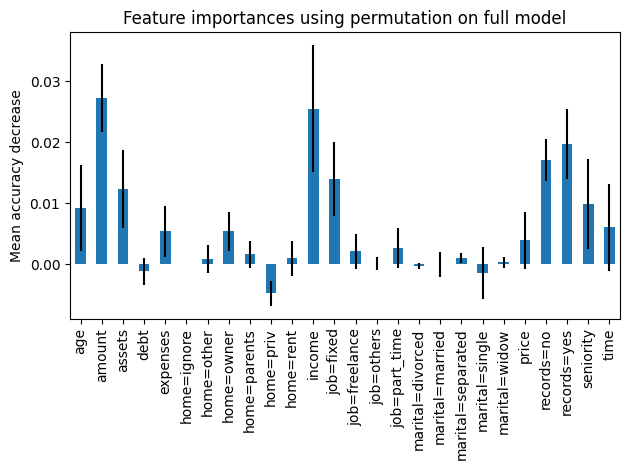

In [183]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()